# The Very Basics of Musical Instruments Classification using Machine Learning
## MFCC, Deep Learning (Gentle introduction using Keras)

<br>

<p align="left">
<img src="./img/businesscard.jpg" width="300px" alt="Business Card" align="left" >
</p>
<br>



In [1]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/ZlxZ3i0RP9I" frameborder="0" 
allow="accelerometer; encrypted-media; gyroscope; picture-in-picture"></iframe>

## Imports

In [32]:
# Imports

#General
import numpy as np
import pickle
import itertools

# System
import os, fnmatch

# Visualization
import seaborn #visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display, Image


# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import classification_report

# Deep Learning
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.optimizers import SGD
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import plot_model

# Random Seed
from tensorflow import set_random_seed
from numpy.random import seed
seed(1)
set_random_seed(2)

# Audio
import librosa.display, librosa

# Configurations
path='./audio/london_phill_dataset_multi/'

## Auxiliary Functions

In [3]:
# Function to Display a Website
def show_web(url):
    html_code='<center><iframe src="%s" width="800" height="600" frameborder="0" marginheight="0" marginwidth="0">Loading...</iframe></center>' \
		% (url)
    display(HTML(html_code))

## Get filenames

In [4]:
# Get files in data path

files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.mp3'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 600 audio files in ./audio/london_phill_dataset_multi/


## Load Labels

In [5]:
filename="inst_labels.pl"
# Load labels
with open(filename, "rb") as f:
    labels = pickle.load( open( filename, "rb" ) )

In [6]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

6 classes: cello, flute, oboe, sax, trumpet, viola


In [38]:
print('Labels:', labels[:3])
print('Encoded Classes: ', classes_num[0:3])

Labels: ['oboe', 'oboe', 'oboe']
Encoded Classes:  [2 2 2]


## Parameters for Train/Test Set

In [7]:
# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing

## Save / Load Feature Vector

In [8]:
filename="mfcc_feature_vectors.pl"
# Load mfcc features from saved file
with open(filename, "rb") as f:
    scaled_feature_vectors = pickle.load( open( filename, "rb" ) )

## Train and Test Sets

In [9]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [10]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (450, 13)
test_set shape: (150, 13)
train_classes shape: (450,)
test_classes shape: (150,)


## Keras

In [11]:
show_web("https://keras.io/")

In [12]:
# DNN
# Use Keras Backend Type
train_set_d=train_set.astype(K.floatx())
test_set_d=test_set.astype(K.floatx())

## One Hot Encoding

In [13]:
# One Hot encode
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
integer_encoded_train_classes =  train_classes.reshape(len( train_classes), 1)
onehot_encoded_train_classes = onehot_encoder.fit_transform(integer_encoded_train_classes,1)
integer_encoded_test_classes =  test_classes.reshape(len( test_classes),1)
onehot_encoded_test_classes = onehot_encoder.fit_transform(integer_encoded_test_classes,1)

In [39]:
print('Integer Encoded:', integer_encoded_train_classes[:3] )
print('One-hot Encoded: ', onehot_encoded_train_classes[:3] )

Integer Encoded: [[0]
 [2]
 [1]]
One-hot Encoded:  [[1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


In [14]:
# Check Set Shapes
print("train_set shape:",train_set_d.shape)
print("test_set shape:",test_set_d.shape)
print("train_classes shape:",onehot_encoded_train_classes.shape)
print("test_classes shape:",onehot_encoded_test_classes.shape)

train_set shape: (450, 13)
test_set shape: (150, 13)
train_classes shape: (450, 6)
test_classes shape: (150, 6)


In [15]:
# Reshape Sets for Keras
train_set_d=train_set.reshape(train_set_d.shape[0],1,train_set_d.shape[1])
test_set_d=test_set.reshape(test_set_d.shape[0],1,test_set_d.shape[1])
train_classes_d_hot=onehot_encoded_train_classes.reshape(onehot_encoded_train_classes.shape[0],1,
                                                         onehot_encoded_train_classes.shape[1])
test_classes_d_hot=onehot_encoded_test_classes.reshape(onehot_encoded_test_classes.shape[0],1,
                                                       onehot_encoded_test_classes.shape[1])

In [16]:
# Check Set Shapes
print("train_set shape:",train_set_d.shape)
print("test_set shape:",train_set_d.shape)
print("train_classes shape:",train_classes_d_hot.shape)
print("test_classes shape:",test_classes_d_hot.shape)

train_set shape: (450, 1, 13)
test_set shape: (450, 1, 13)
train_classes shape: (450, 1, 6)
test_classes shape: (150, 1, 6)


In [17]:
show_web("https://keras.io/models/model/")

## Create a Model

In [18]:
# Creat Simple Model
model_input = Input(shape=(1,train_set.shape[1]))
fc1 = Dense(12, activation="relu")(model_input)
fc2 = Dense(10, activation="relu")(fc1)
fc3 = Dense(8, activation="relu")(fc2)
fc4 = Dense(6, activation="relu")(fc2)
n=onehot_encoded_train_classes.shape[1]
out = Dense(n, activation="softmax")(fc4)
model_d = Model(inputs=[model_input], outputs=[out])
model_d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 13)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 12)             168       
_________________________________________________________________
dense_2 (Dense)              (None, 1, 10)             130       
_________________________________________________________________
dense_4 (Dense)              (None, 1, 6)              66        
_________________________________________________________________
dense_5 (Dense)              (None, 1, 6)              42        
Total params: 406
Trainable params: 406
Non-trainable params: 0
_________________________________________________________________


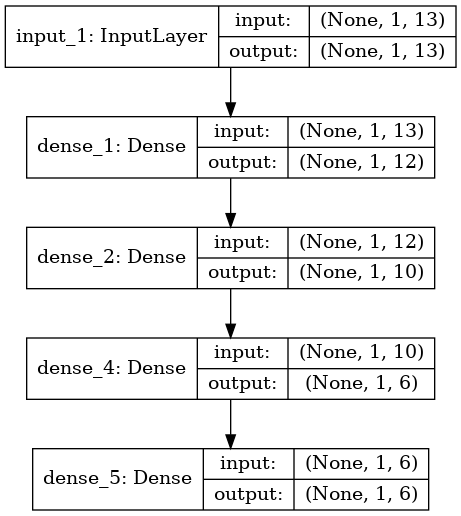

In [33]:
plot_model(model_d, to_file='model_d.png', show_shapes=True)
Image('model_d.png')

## Compile a Model

In [20]:
# Compile Model
model_d.compile(loss      = 'categorical_crossentropy',
              optimizer = SGD(lr=0.05),
              metrics   =['accuracy'])

## Train a Model

In [21]:
# Deep Learning Parameters
batch_size = 5 # Number of samples per gradient update.
epochs = 200    # An epoch is an iteration over the entire x and y data provided.

# Train Model
hist = model_d.fit(train_set_d, train_classes_d_hot, verbose=1, 
                    batch_size=batch_size, epochs=epochs, validation_data=(test_set_d,test_classes_d_hot))

Train on 450 samples, validate on 150 samples
Epoch 1/200
450/450 [==============================] - 1s 2ms/step - loss: 1.5589 - acc: 0.3778 - val_loss: 1.3347 - val_acc: 0.4400
Epoch 2/200
450/450 [==============================] - 0s 724us/step - loss: 1.0163 - acc: 0.6333 - val_loss: 0.8263 - val_acc: 0.6867
Epoch 3/200
450/450 [==============================] - 0s 867us/step - loss: 0.6395 - acc: 0.7622 - val_loss: 0.6284 - val_acc: 0.7733
Epoch 4/200
450/450 [==============================] - 0s 851us/step - loss: 0.4400 - acc: 0.8489 - val_loss: 0.4398 - val_acc: 0.8400
Epoch 5/200
450/450 [==============================] - 0s 717us/step - loss: 0.3216 - acc: 0.9000 - val_loss: 0.3727 - val_acc: 0.9000
Epoch 6/200
450/450 [==============================] - 0s 851us/step - loss: 0.2557 - acc: 0.9178 - val_loss: 0.2606 - val_acc: 0.9400
Epoch 7/200
450/450 [==============================] - 0s 709us/step - loss: 0.1910 - acc: 0.9556 - val_loss: 0.2231 - val_acc: 0.9600
Epoch 8/200

Epoch 61/200
450/450 [==============================] - 0s 736us/step - loss: 0.0171 - acc: 0.9956 - val_loss: 0.2485 - val_acc: 0.9467
Epoch 62/200
450/450 [==============================] - 0s 789us/step - loss: 0.0170 - acc: 0.9956 - val_loss: 0.2504 - val_acc: 0.9600
Epoch 63/200
450/450 [==============================] - 0s 689us/step - loss: 0.0167 - acc: 0.9956 - val_loss: 0.2452 - val_acc: 0.9600
Epoch 64/200
450/450 [==============================] - 0s 697us/step - loss: 0.0161 - acc: 0.9956 - val_loss: 0.2494 - val_acc: 0.9467
Epoch 65/200
450/450 [==============================] - 0s 684us/step - loss: 0.0164 - acc: 0.9956 - val_loss: 0.2534 - val_acc: 0.9533
Epoch 66/200
450/450 [==============================] - 0s 811us/step - loss: 0.0151 - acc: 0.9956 - val_loss: 0.2542 - val_acc: 0.9467
Epoch 67/200
450/450 [==============================] - 0s 726us/step - loss: 0.0152 - acc: 0.9956 - val_loss: 0.2604 - val_acc: 0.9533
Epoch 68/200
450/450 [==========================

450/450 [==============================] - 0s 731us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.2869 - val_acc: 0.9667
Epoch 122/200
450/450 [==============================] - 0s 767us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.2858 - val_acc: 0.9667
Epoch 123/200
450/450 [==============================] - 0s 716us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.2875 - val_acc: 0.9667
Epoch 124/200
450/450 [==============================] - 0s 887us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.2882 - val_acc: 0.9667
Epoch 125/200
450/450 [==============================] - 0s 772us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.2904 - val_acc: 0.9667
Epoch 126/200
450/450 [==============================] - 0s 770us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.2903 - val_acc: 0.9667
Epoch 127/200
450/450 [==============================] - 0s 760us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.2898 - val_acc: 0.9667
Epoch 128/200
450/450 [==============================] 

450/450 [==============================] - 0s 823us/step - loss: 4.0350e-04 - acc: 1.0000 - val_loss: 0.2951 - val_acc: 0.9667
Epoch 180/200
450/450 [==============================] - 0s 713us/step - loss: 3.9435e-04 - acc: 1.0000 - val_loss: 0.2953 - val_acc: 0.9667
Epoch 181/200
450/450 [==============================] - 0s 840us/step - loss: 3.9606e-04 - acc: 1.0000 - val_loss: 0.2952 - val_acc: 0.9667
Epoch 182/200
450/450 [==============================] - 0s 701us/step - loss: 3.8778e-04 - acc: 1.0000 - val_loss: 0.2954 - val_acc: 0.9667
Epoch 183/200
450/450 [==============================] - 0s 846us/step - loss: 3.8191e-04 - acc: 1.0000 - val_loss: 0.2957 - val_acc: 0.9667
Epoch 184/200
450/450 [==============================] - 0s 714us/step - loss: 3.7729e-04 - acc: 1.0000 - val_loss: 0.2953 - val_acc: 0.9667
Epoch 185/200
450/450 [==============================] - 0s 808us/step - loss: 3.7426e-04 - acc: 1.0000 - val_loss: 0.2953 - val_acc: 0.9667
Epoch 186/200
450/450 [====

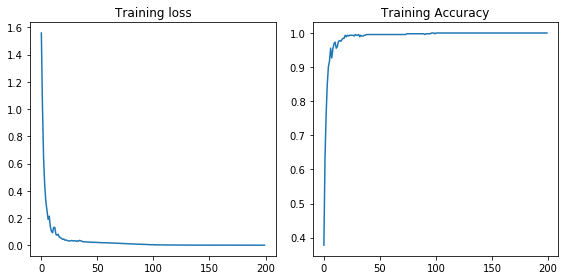

In [22]:
# Plot Training Loss and Training Accuracy
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.title("Training loss")
plt.plot(range(epochs),hist.history["loss"])

plt.subplot(1, 2, 2)
plt.title("Training Accuracy")
plt.plot(range(epochs),hist.history["acc"])

plt.tight_layout()

## Make Predictions

In [23]:
# Predict
predictions = model_d.predict(test_set_d)
predictions_round=predictions.round().astype('int')
predictions_int=np.argmax(predictions_round,axis=2)
predictions_labels=labelencoder.inverse_transform(np.ravel(predictions_int))

## Evaluation

In [24]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predictions_int,average=None))

# Precision - The precision is intuitively the ability of the classifier not to label as positive a sample that is negatives
print("Precision: ", precision_score(test_classes, predictions_int,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision and recall,
print("F1-Score: ", f1_score(test_classes, predictions_int, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: ", accuracy_score(test_classes, predictions_int,normalize=False))
print("Number of samples:",test_classes.shape[0])

Recall:  [0.92 1.   1.   1.   0.92 0.96]
Precision:  [1.         1.         1.         0.92592593 0.95833333 0.92307692]
F1-Score:  [0.95833333 1.         1.         0.96153846 0.93877551 0.94117647]
Accuracy:  145
Number of samples: 150


In [25]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predictions_int)
np.set_printoptions(precision=2)

In [26]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

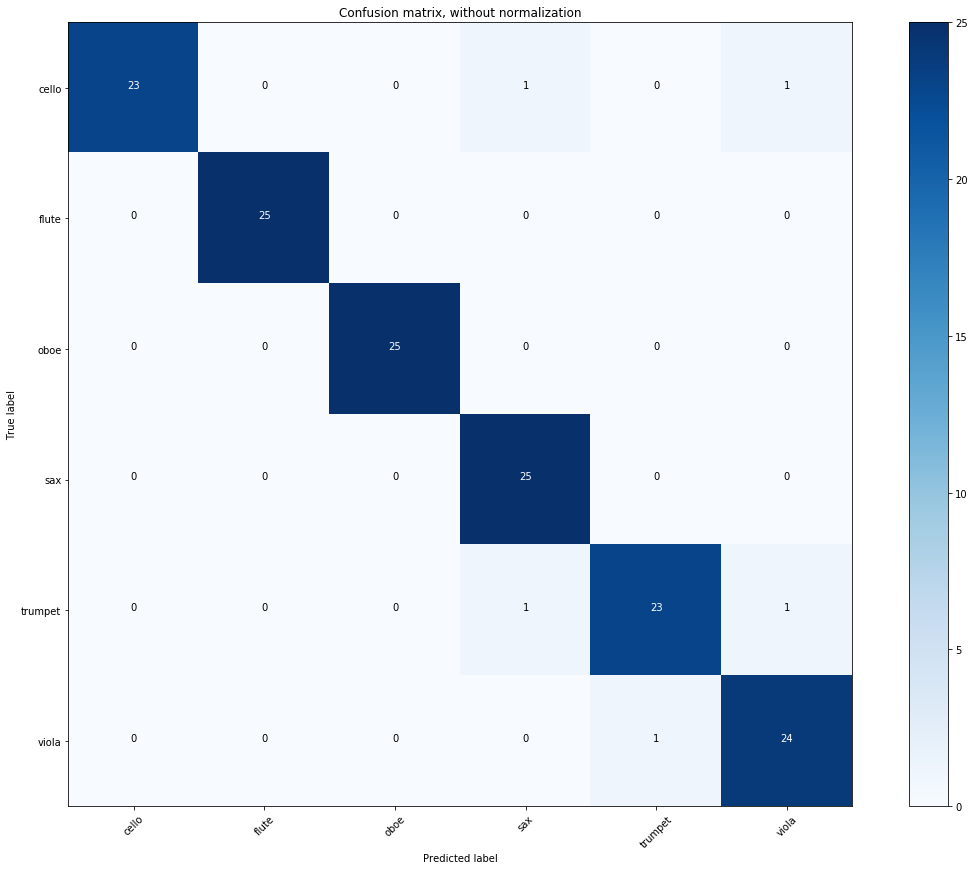

In [27]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [28]:
# Find wrong predicted samples indexes
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predictions_int)) if e1 != e2]

In [29]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predictions_labels[wrong_predictions].T)
print(np.array(files)[test_index[wrong_predictions]])

['viola' 'cello' 'cello' 'trumpet' 'trumpet']
['trumpet' 'viola' 'sax' 'sax' 'viola']
['./audio/london_phill_dataset_multi/viola/viola_A4_15_pianissimo_arco-normal.mp3'
 './audio/london_phill_dataset_multi/cello/cello_A2_025_fortissimo_arco-normal.mp3'
 './audio/london_phill_dataset_multi/cello/cello_Gs3_05_forte_arco-normal.mp3'
 './audio/london_phill_dataset_multi/trumpet/trumpet_A3_05_forte_normal.mp3'
 './audio/london_phill_dataset_multi/trumpet/trumpet_Cs4_15_pianissimo_normal.mp3']


In [30]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

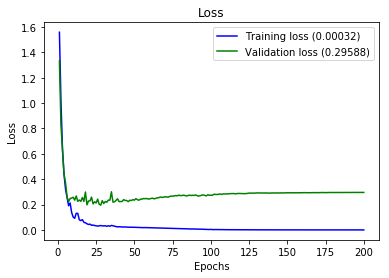

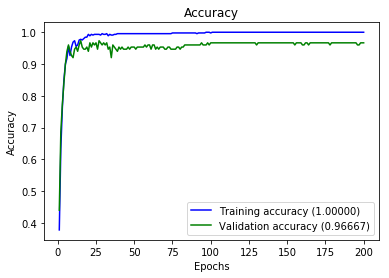

In [31]:
plot_history(hist)